# Solving a Krichhoff plate blending problem with Morley element
Problem:
$$ \Delta^2 u = f \  in \ \Omega$$ 
$$  u = \frac{\partial u}{\partial \boldsymbol{n}} = 0 \ on \ \Gamma$$
note:
$$\Delta^{2} \equiv \nabla^{4}=\frac{\partial^{4}}{\partial x^{4}}+2 \frac{\partial^{4}}{\partial x^{2} \partial y^{2}}+\frac{\partial^{4}}{\partial y^{4}}$$
In this case, we consider $\Omega=(0,1) \times(0,1)$ and try
$$ 
f(x, y)=24\left[\left(x^{2}-x+1\right)^{2}+\left(y^{2}-y+1\right)^{2}+12\left(x^{2}-x\right)\left(y^{2}-y\right)\right]-40
$$
from 
$$
u(x, y)=x^{2}(1-x)^{2} y^{2}(1-y)^{2}
$$
We can write the problem as:
$$ \int_\Omega \boldsymbol{K}(u) : \boldsymbol{K}(v) \,\mathrm{d}x = \int_\Omega fv \,\mathrm{d}x \quad \forall v \in V $$

In [19]:
from skfem.models.poisson import unit_load
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov, solver_eigen_scipy, solver_iter_pcg
from skfem.helpers import d, dd, ddot
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 500

## Assembling $K$ $f$ and storing boundary condition in `D`
mesh refined with m.refine(5)

In [20]:
# m = MeshTri()
m = MeshTri.init_symmetric()
m.refine(2)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    return ddot(dd(u), dd(v))


@LinearForm
def mybih(v, w):
    x, y = w.x
    return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                  (y - 1) * x * y) - 40) * v


dofs = ib.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                    dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                    dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))

K = asm(bilinf, ib)
f = asm(mybih, ib)

## Plotting the quadrature points of each triangle

In [22]:
# x = ib.global_coordinates().value  # coordinates [x, y]
# # x.shape

# for i in range(x.shape[1]):
#     plt.scatter(x[0][i], x[1][i], s=60, marker='*')
#     # plt.show()

## Solving $Ku = f$ using `pcg`

In [4]:
%%time
u = solve(*condense(K, f, D=D), solver=solver_iter_pcg())

Wall time: 2 ms


## Plotting results ${u}_{h}$

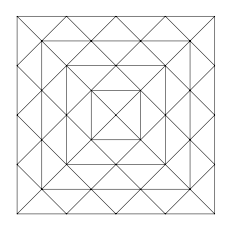

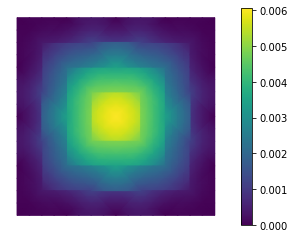

In [5]:
ax = draw(m)
# plot(ib, u, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)
plot(ib, u, shading='gouraud', colorbar=True, Nrefs=2)
plt.show()

## Error estimating

### Setting boundary and forms

In [6]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D


@BilinearForm
def bilinf(u, v, w):
    return ddot(dd(u), dd(v))


@LinearForm
def mybih(v, w):
    x, y = w.x
    return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                  (y - 1) * x * y) - 40) * v

### Defining $u$ $Du$ and $D^{2}u$

In [7]:
def exact(x, y):
    return (x * y * (1 - x) * (1 - y))**2


def dexact(x, y):
    dux = (y * (1 - y))**2 * (4 * x**3 - 6 * x**2 + 2 * x)
    duy = (x * (1 - x))**2 * (4 * y**3 - 6 * y**2 + 2 * y)
    return dux, duy


def ddexact(x, y):
    duxx = (12 * x**2 - 12 * x + 2) * (y * (1 - y))**2 
    duxy = (4 * x**3 - 6 * x**2 + 2 * x) * (4 * y**3 - 6 * y**2 + 2 * y)
    duyx = duxy
    duyy = (12 * y**2 - 12 * y + 2) * (x * (1 - x))**2 
    return duxx, duxy, duyx, duyy

### Defining $L2$ and $H1$ norm

In [14]:
@Functional
def L2Error(w):
    x, y = w.x
    return (w.w - exact(x, y))**2

def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_cboordinates().value  # coordinates [x, y]
    dx = basis.dx # quadrature weights
    dux, duy = dexact(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))

### Defining $H2$ norm

In [15]:
def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates().value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

### Convergence

In [16]:
L2_list = []
Du_list = []
D2u_list = []
h_list = []
# m = MeshTri()
m = MeshTri.init_symmetric()

pre_refine = 0
test_refine = 7

m.refine(pre_refine)

for i in range(test_refine):
    m.refine()

    e = ElementTriMorley()
    ib = InteriorBasis(m, e)

    K = asm(bilinf, ib)
    f = asm(mybih, ib)
    D = easy_boundary(ib)

    uh = solve(*condense(K, f, D=D), solver=solver_iter_pcg())

    U = ib.interpolate(uh).value

    L2 = np.sqrt(L2Error.assemble(ib, w=U))
    L2_list.append(L2)

    Du = get_DuError(ib, uh)
    Du_list.append(Du)

    D2u = get_D2uError(ib, uh)
    D2u_list.append(D2u)

    h_list.append(m.param())
    print('case 2^-' + str(i + 1 + pre_refine))
    print('L2 Error:', L2)
    print('Du Error:', Du)
    print('D2u Error:', D2u)
    # print('hs', m.param())

case 2^-1
L2 Error: 0.0034956548391022716
Du Error: 0.008900246017294602
D2u Error: 0.08333525631614903
case 2^-2
L2 Error: 0.0009229599708154967
Du Error: 0.00257779391263518
D2u Error: 0.042870779571728954
case 2^-3
L2 Error: 0.00024556475310836477
Du Error: 0.0007198526914286134
D2u Error: 0.0222395246707216
case 2^-4
L2 Error: 6.268071879275607e-05
Du Error: 0.00018668007350486392
D2u Error: 0.011261022941320727
case 2^-5
L2 Error: 1.5759368972803695e-05
Du Error: 4.714067630785026e-05
D2u Error: 0.005649991438292255
case 2^-6
L2 Error: 3.945597658796332e-06
Du Error: 1.1815672522641127e-05
D2u Error: 0.0028274994282478792
case 2^-7
L2 Error: 9.867624370423945e-07
Du Error: 2.9558442943084687e-06
D2u Error: 0.0014140650099388


In [17]:
hs = np.array(h_list)
L2s = np.array(L2_list)
Dus = np.array(Du_list)
D2us = np.array(D2u_list)

H1s = L2s + Dus
H2s = H1s + D2us

### Convergence Rate

In [18]:
print('  h    L2s   H1s   H2s')
for i in range(H2s.shape[0] - 1):
    print(
        '2^-' + str(i + 2 + pre_refine),
        ' {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                         -np.log2(H1s[i + 1] / H1s[i]),
                                         -np.log2(H2s[i + 1] / H2s[i])))

  h    L2s   H1s   H2s
2^-2  1.92  1.82  1.05
2^-3  1.91  1.86  1.00
2^-4  1.97  1.95  1.01
2^-5  1.99  1.99  1.01
2^-6  2.00  2.00  1.01
2^-7  2.00  2.00  1.00


### Figure

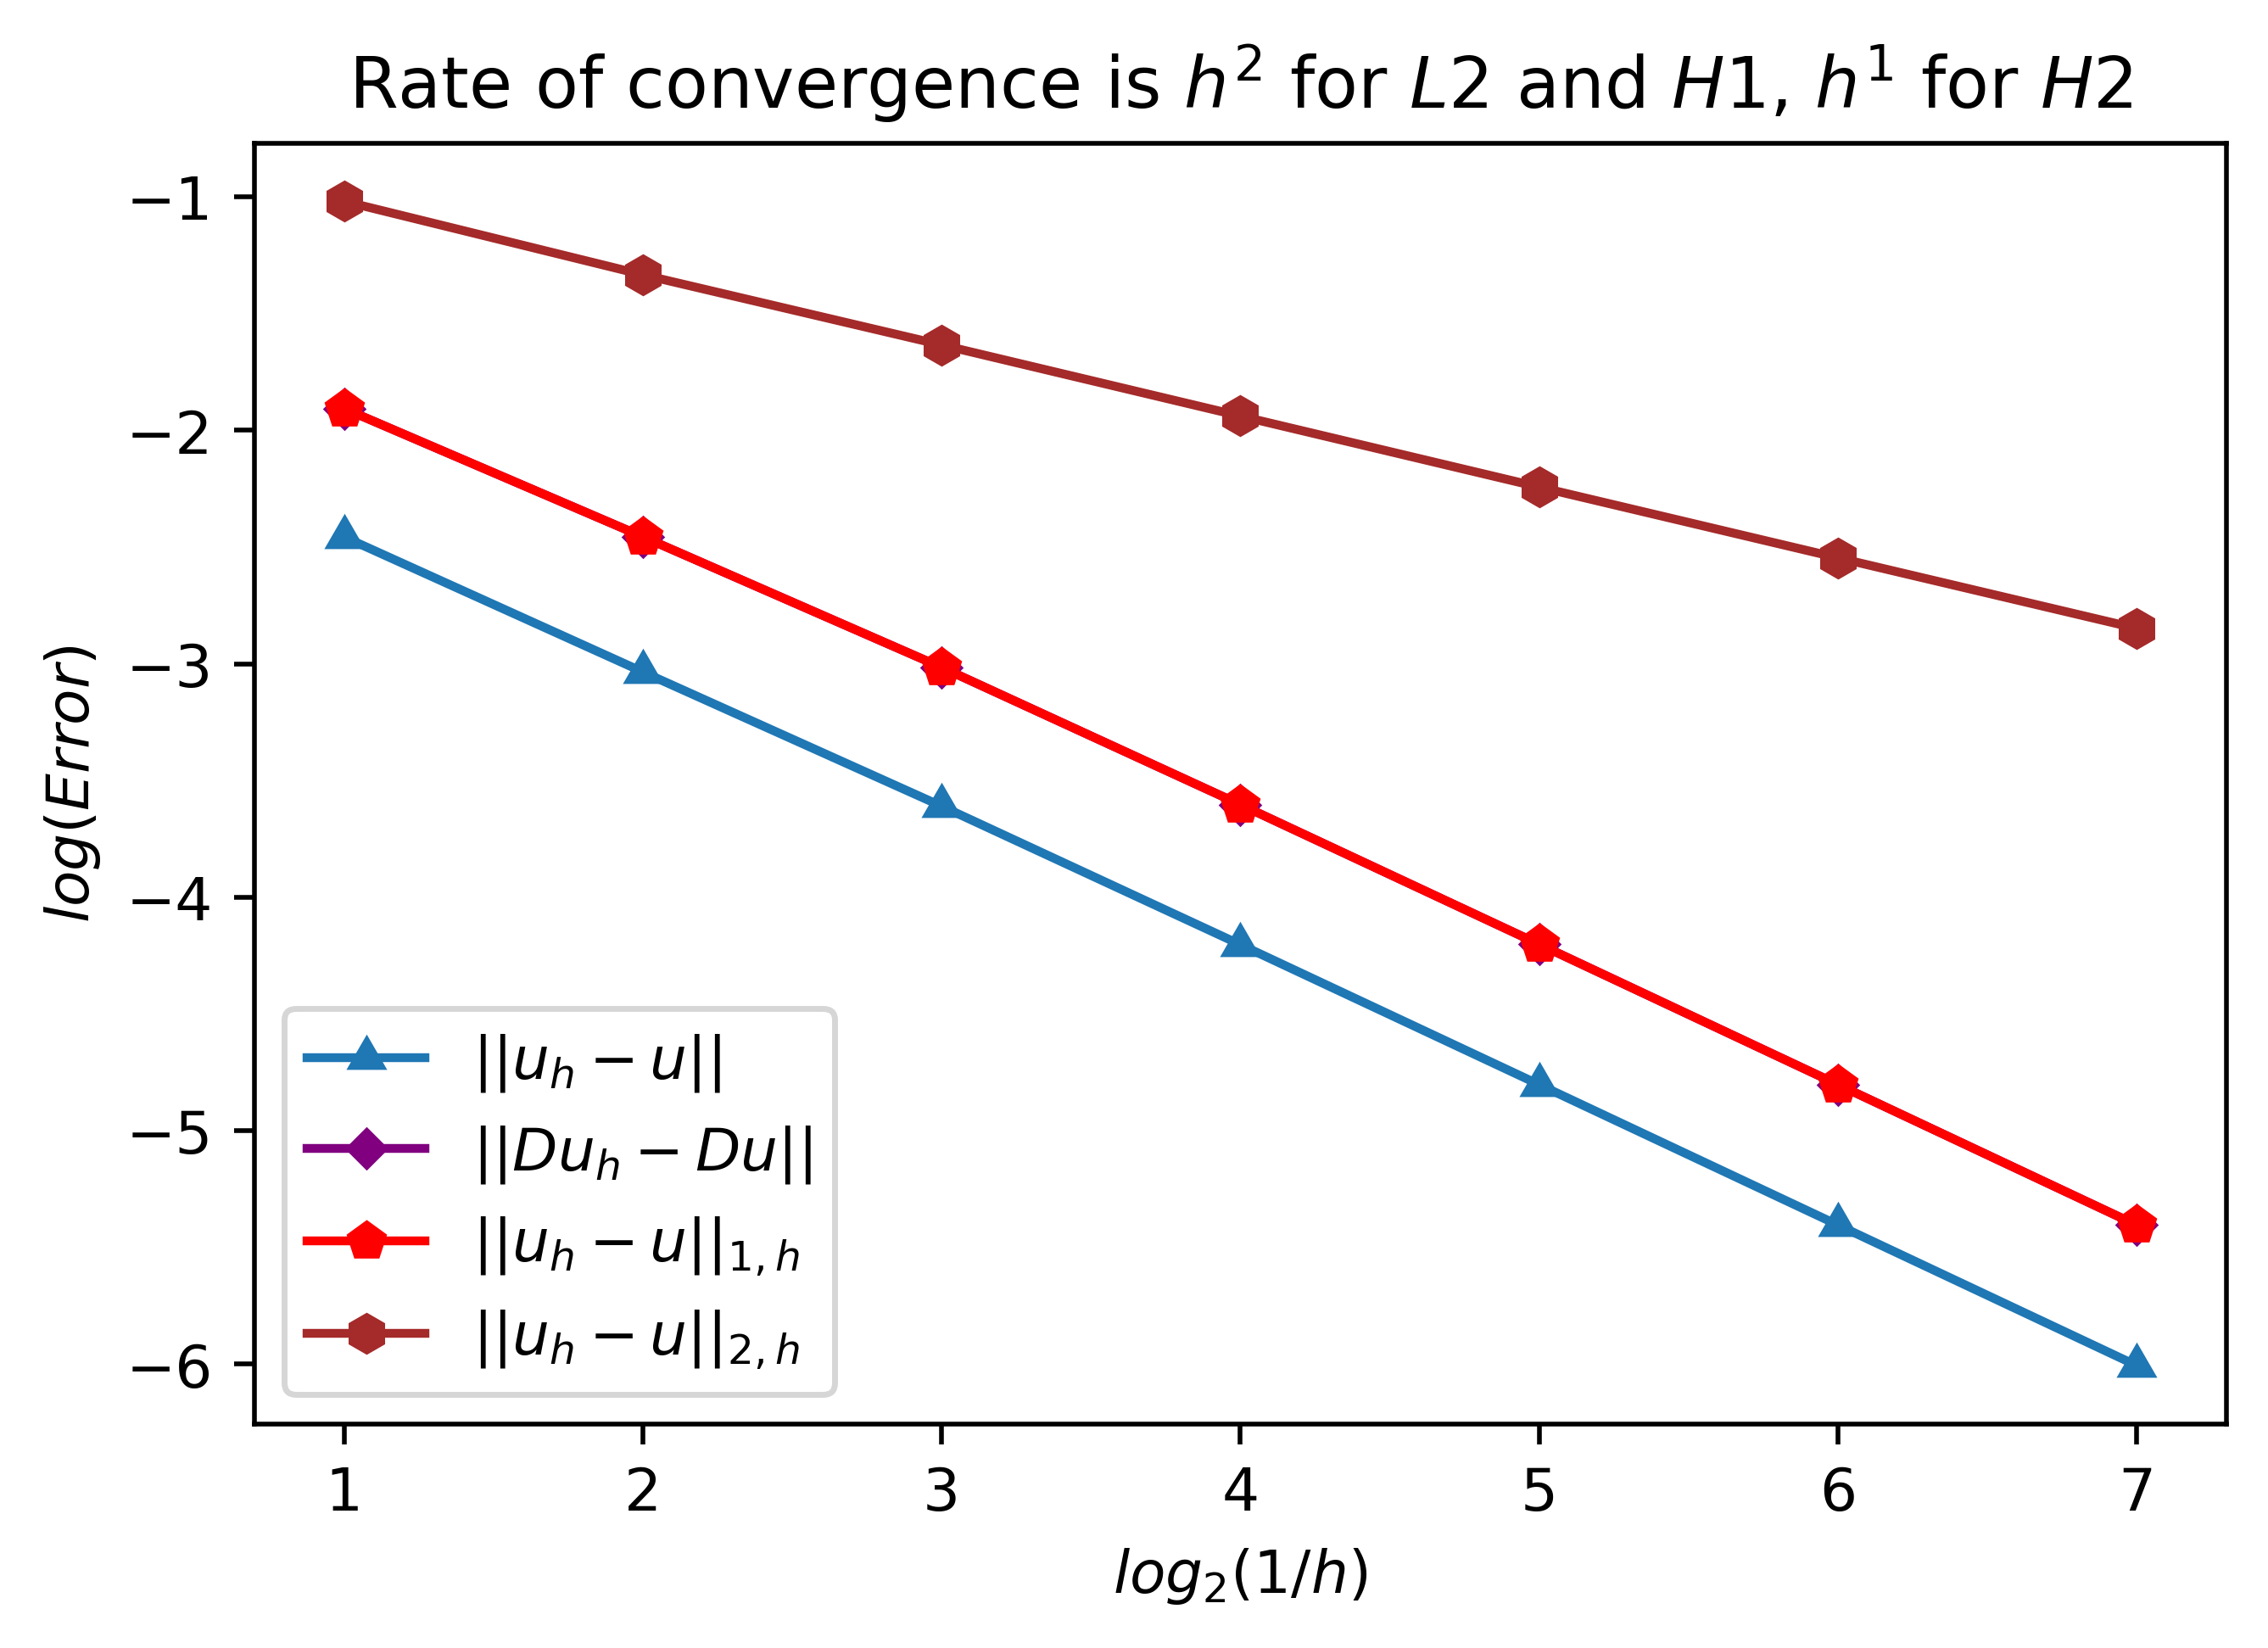

In [23]:
hs_Log = np.log2(hs)

L2plot, = plt.plot(-hs_Log,
                   np.log10(L2s),
                   marker=(3, 0),
                   label='$|\|u_{h}-u\||}$')
Duplot, = plt.plot(-hs_Log,
                   np.log10(H1s),
                   marker=(4, 0),
                   label=r'$|\left\|{Du}_{h}-Du\right\||$',
                   color='purple')
H1plot, = plt.plot(-hs_Log,
                   np.log10(H1s),
                   marker=(5, 0),
                   label=r'$|\left\|{u}_{h}-u\right\||_{1, h}$',
                   color='red')
H2plot, = plt.plot(-hs_Log,
                   np.log10(H2s),
                   marker=(6, 0),
                   label=r'$|\left\|{u}_{h}-u\right\||_{2, h}$',
                   color='brown')

plt.legend(handles=[L2plot, Duplot, H1plot, H2plot])
plt.title('Rate of convergence is $h^{2}$ for $L2$ and $H1$, $h^{1}$ for $H2$')
plt.xlabel('$log_{2}(1/h)$')
plt.ylabel('$log(Error)$')
plt.show()